# Исследование поведения пользователей мобильного приложения для стартапа по доставке продуктов

Мы помогаем с аналитикой стартапу, который продает продукты питания. Нужно разобраться, как ведут себя пользователи мобильного приложения.

Сначала изучим воронку продаж и узнаем, как пользователи доходят до покупки. Сколько пользователей делают заказы, а сколько — «застревает» на предыдущих шагах? На каких именно?

Затем исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всем приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.

## Содержание<a name="Содержание"></a>

1. [Знакомство с данными](#1.-Знакомство-с-данными)
2. [Подготовка данных](#2.-Подготовка-данных)
3. [Изучение и проверка данных](#3.-Изучение-и-проверка-данных)
	1. [Количество событий](#Количество-событий)
	2. [Количество пользователей](#Количество-пользователей)
	3. [Среднее число событий на одного пользователя](#Среднее-число-событий-на-одного-пользователя)
	4. [Выбор временного периода](#Выбор-временного-периода)
4. [Анализ воронки событий](#4.-Анализ-воронки-событий)
	1. [Частота событий в логе](#Частота-событий-в-логе)
	2. [Сколько пользователей совершили каждое действие](#Сколько-пользователей-совершили-каждое-действие)
	3. [Воронка событий](#Воронка-событий)
5. [Анализ результатов A/A/B-теста](#5.-Анализ-результатов-A/A/B-теста)
	1. [Размеры групп](#Размеры-групп)
	2. [Результаты A/A-теста](#Результаты-A/A-теста)
	3. [Результаты A/B-теста](#Результаты-A/B-теста)
6. [Общий вывод](#Общий-вывод)
	1. [Воронка событий](#Воронка-событий)
	2. [A/A-тест](#A/A-тест)
	3. [A/B-тест](#A/B-тест)

## 0. Импорт библиотек

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go

from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest

In [2]:
sns.set_style('darkgrid')

## 1. Знакомство с данными<a name="1.-Знакомство-с-данными"></a>

Сохраним данные в переменную `logs` и посмотрим на первые строчки.

In [3]:
logs = pd.read_csv('logs_exp.csv', sep='\t')
logs.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


Каждая запись в логе — это действие пользователя, или событие.
- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, 248 — экспериментальная.

Посмотрим на общую информацию о данных.

In [4]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Нам повезло, в данных нет пропусков. Но проблемы все равно есть:
1. У признаков неудобные названия столбцов.
2. У `EventTimestamp` неправильный тип данных. Должен быть `datetime`.
3. У `ExpId` можно понизить размерность.

[К содержанию](#Содержание)

## 2. Подготовка данных<a name="2.-Подготовка-данных"></a>

### Переименования столбцов

Заменим названия параметров на более удобные.

In [5]:
logs = logs.rename(columns={
    'EventName': 'event',
    'DeviceIDHash': 'user_id',
    'EventTimestamp': 'timestamp',
    'ExpId': 'group'
})

logs.columns

Index(['event', 'user_id', 'timestamp', 'group'], dtype='object')

### Замена типа данных

Поменяем тип данных `timestamp` с `int` на `datetime`. Посмотрим на результат.

In [6]:
logs['timestamp'] = pd.to_datetime(logs['timestamp'], unit='s')
logs.head(3)

,event,user_id,timestamp,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248


Понизим размерность номеров экспериментов.

In [7]:
logs['group'] = pd.to_numeric(logs['group'], downcast='unsigned')

print('Новая размерность столбца group:', logs['group'].dtype)

Новая размерность столбца group: uint8


### Обработка дубликатов

Проверим, есть ли в данных дубликаты.

In [8]:
print('Количество дубликатов:', logs.duplicated().sum())

Количество дубликатов: 413


Нашлось 413 дубликатов. Удалим их и удостоверимся, что они пропали.

In [9]:
logs = logs.drop_duplicates().reset_index(drop= True)

print('Количество дубликатов:', logs.duplicated().sum())

Количество дубликатов: 0


### Пользователи, попавшие в обе группы

Проверим, есть ли пользователи, которые попали в несколько групп теста.

In [10]:
n_groups_for_user = (logs
                     .groupby('user_id', as_index=False)
                     .agg({'group':'nunique'}))
n_groups_for_user.head()

,user_id,group
0,6888746892508752,1
1,6909561520679493,1
2,6922444491712477,1
3,7435777799948366,1
4,7702139951469979,1


In [11]:
n_groups_for_user.query('group > 1')

,user_id,group


Пользователей, которые попали в несколько групп, нет — хорошо.

### Выделение даты в отдельный столбец

Добавим в `logs` новый столбец с датой события и посмотрим на таблицу.

In [12]:
logs['date'] = pd.to_datetime(logs['timestamp'].dt.date)
logs.head(5)

,event,user_id,timestamp,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


### Вывод

При знакомстве с данными мы нашли несколько проблем и сейчас исправили их. А именно:
1. Поменяли названия столбцов на удобные и говорящие.
2. Поменяли тип данных `timestamp` с неправильного `int` на подходящий `datetime`.
3. Понизили размерность столбца `group` с `int64` до `uin8`.
4. Нашли в данных дубликаты и удалили их.
5. Проверили, что пользователи не меняли свои группы во время теста.

Также мы добавили в таблицу новый столбец `date` с датами событий, так как они понадобятся нам во время исследования.

Подготовка данных завершена, и мы можем переходить к анализу.

[К содержанию](#Содержание)

## 3. Изучение и проверка данных<a name="3.-Изучение-и-проверка-данных"></a>

### Количество событий<a name="Количество-событий"></a>

Найдем число всех событий в логе — это количество строк в таблице `logs`.

In [13]:
n_events = len(logs)
n_events

243713

В логе больше 240 тысяч событий. Посмотрим, какими они бывают и сколько раз повторялось каждое.

In [14]:
logs['event'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event, dtype: int64

Видим, что:
- больше 119 тысяч раз пользователи открывали главный экран;
- на экран с товарами переходили почти 47 тысяч раз;
- до корзины доходили чуть меньше 43 тысяч раз;
- успешно оплатили покупку больше 34 тысяч раз;
- обучение прошли 1018 раз.

### Количество пользователей<a name="Количество-пользователей"></a>

Посчитаем пользователей. Для этого найдем число уникальных значений в столбце `user_id`.

In [15]:
n_users = logs['user_id'].nunique()

print('Число пользователей:', n_users)

Число пользователей: 7551


### Среднее число событий на одного пользователя<a name="Среднее-число-событий-на-одного-пользователя"></a>

Найдем, сколько в среднем событий приходится на пользователя. Для этого разделим количество событий на количество пользователей.

In [16]:
n_events_per_user = n_events / n_users
n_events_per_user

32.27559263673685

Среднее количество событий на пользователя — 32.

Посмотрим на распределение числа действий по количеству пользователей, чтобы понять, насколько среднее количество событий на пользователя показательно.

In [17]:
logs_grouped_by_users = (logs
                         .groupby('user_id')
                         .agg({'event': 'count'})
                         .reset_index())
logs_grouped_by_users.columns = ['user_id', 'n_events']

logs_grouped_by_users.head()

,user_id,n_events
0,6888746892508752,1
1,6909561520679493,5
2,6922444491712477,47
3,7435777799948366,6
4,7702139951469979,137


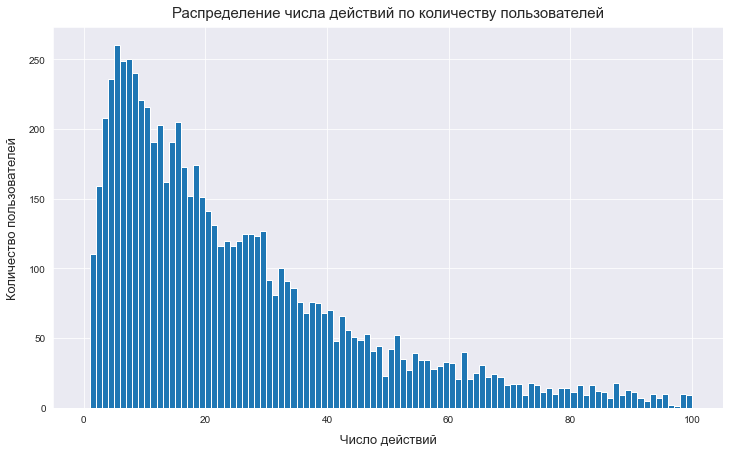

In [18]:
plt.figure(figsize=(12, 7))
logs_grouped_by_users['n_events'].hist(bins=100, range=(0,100))

plt.title('Распределение числа действий по количеству пользователей', fontsize=15, y=1.01)
plt.xlabel('Число действий', fontsize=13, labelpad=10)
plt.ylabel('Количество пользователей', fontsize=13, labelpad=10)

logs_by_users_graph = plt.gcf()

Распределение сильно скошено вправо. Поэтому в качестве меры центральной тенденции логичнее взять моду, а не среднее.

In [19]:
n_events_mode = logs_grouped_by_users['n_events'].mode()[0]

print('Мода количества действий на пользователя:', n_events_mode)

Мода количества действий на пользователя: 5


Чаще всего пользователи совершают 5 действий, то есть в шесть раз меньше среднего значения.

### Выбор временного периода<a name="Выбор-временного-периода"></a>

Посмотрим за какой период наши данные.

In [20]:
print('Дата первого лога:', logs['date'].min())
print('Дата последнего лога:', logs['date'].max())

Дата первого лога: 2019-07-25 00:00:00
Дата последнего лога: 2019-08-07 00:00:00


У нас есть данные за две недели с 25 июля по 7 августа 2019 года.

Посмотрим на количество логов по дням.

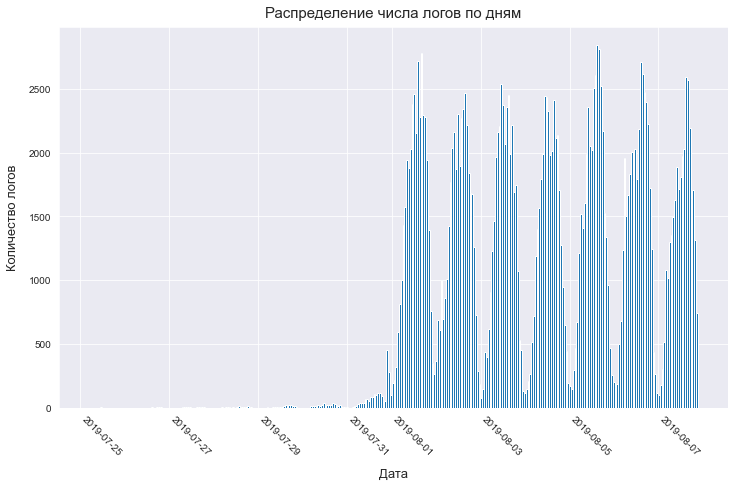

In [21]:
plt.figure(figsize=(12, 7))
logs['timestamp'].hist(bins=336) # 336 — это две недели в часах (14*24)

plt.xticks(rotation=-45, ha="left")
plt.title('Распределение числа логов по дням', fontsize=15, y=1.01)
plt.xlabel('Дата', fontsize=13, labelpad=10)
plt.ylabel('Количество логов', fontsize=13, labelpad=10)

n_events_by_day_graph = plt.gcf()

Видно, что до 1 августа логов гораздо меньше, чем в период с 1 по 7. Скорее всего, логи до 1 августа попали к нам случайно. Возможно, они «доехали» с устройств пользователей в базу с опозданием, а действия отбирались не по дате свершения, а по времени записи в базу.

В общем, на самом деле мы располагаем данными за неделю с 1 по 7 августа. 

Также можно заметить дневную сезонность: ранним утром и поздним вечером логов приходит гораздо меньше, чем днем. Значит, в это время активность в приложении падает.

#### Старые логи

Посчитаем, сколько событий и пользователей попали в старые логи.

In [22]:
old_logs = logs[logs['date']<pd.to_datetime('2019-08-01')]
old_logs.head()

,event,user_id,timestamp,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [23]:
print('\033[1m' + 'Старые события' + '\033[0m')
print(f'Количество: {len(old_logs)}')
print(f'Доля от общего числа: {len(old_logs)/len(logs):.2%}')

Старые события
Количество: 2826
Доля от общего числа: 1.16%


Старых событий меньше трех тысяч, или 1,16% от всех данных.

In [24]:
old_users = set(old_logs['user_id'].unique())
new_users = set(logs[logs['date']>=pd.Timestamp('2019-08-01')]['user_id'].unique())

users_loss = len(old_users - new_users)
all_users = logs['user_id'].nunique()

In [25]:
print('\033[1m' + 'Пользователи из старых логов, которых нет в новых' + '\033[0m')
print('Число:', users_loss)
print(f'Доля от общего количества: {users_loss / all_users:.2%}')

Пользователи из старых логов, которых нет в новых
Число: 17
Доля от общего количества: 0.23%


Отбросив старые данные, мы потеряем всего 17 пользователей, или 0,23% всех пользователей.

Оставим в `logs` только новые логи.

In [26]:
logs = logs[logs['date']>=pd.Timestamp('2019-08-01')]

### Проверка числа экспериментальных групп

В логах должны быть данные о трех группах с номерами 246, 247 и 248. Удостоверимся, что это так.

In [27]:
logs['group'].unique()

array([246, 247, 248], dtype=uint8)

В логах действительно есть все нужные группы.

### Вывод

Мы узнали, что у нас есть данные о 240 тысячах событий и 7,5 тысячах пользователей. События деляются на пять видов:
1. посещение главного экрана;
2. переход на экран с продуктами;
3. просмотр корзины;
4. экран с уведомлением об успешном заказе;
5. прохождение обучения.

Нашли, что среднее количество действий на пользователя — 32. Но чаще всего пользователи совершают всего 5 действий.

Дальше мы проверили, за какой период наши данные — за 1–7 августа 2019 года. 

Во время проверки мы обнаружили в логах события до 1 августа: 17 пользователей (0,23% от общего числа) совершили около 3 тысяч событий (меньше 1,5% от всех). Скорее всего, эти данные попали к нам из-за технического сбоя, поэтому мы избавились от них. 

В конце удостоверились, что логи содержат информцию обо всех экспериментах.

[К содержанию](#Содержание)

## 4. Анализ воронки событий<a name="4.-Анализ-воронки-событий"></a>

Изучим воронку продаж и узнаем, как пользователи доходят до покупки.

### Частота событий в логе<a name="Частота-событий-в-логе"></a>

Посмотрим, как изменилась частота событий в логе после удаления старых данных.

In [28]:
logs['event'].value_counts().reset_index()

,index,event
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


Видим, что:
- больше 117 тысяч раз пользователи открывали главный экран;
- на экран с товарами переходили больше 46 тысяч раз;
- до корзины доходили больше 42 тысяч раз;
- успешно оплатили покупку чуть меньше 34 тысяч раз;
- обучение прошли 1005 раз.

### Сколько пользователей совершили каждое действие<a name="Сколько-пользователей-совершили-каждое-действие"></a>

Посчитаем, сколько пользователей совершали каждое действие. 

In [29]:
n_users_by_event = (logs
                    .groupby('event')
                    .agg({'user_id': 'nunique'})
                    .reset_index())
n_users_by_event.columns = ['event', 'n_users']

n_users_by_event = (n_users_by_event
                    .sort_values(by='n_users', ascending=False)
                    .reset_index(drop=True))
n_users_by_event

,event,n_users
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


Для каждого события найдем долю пользователей, которые хоть раз совершали его.

In [30]:
n_users_by_event['percent_of_total'] = round(n_users_by_event['n_users'] / n_users * 100, 2)
n_users_by_event

,event,n_users,percent_of_total
0,MainScreenAppear,7419,98.25
1,OffersScreenAppear,4593,60.83
2,CartScreenAppear,3734,49.45
3,PaymentScreenSuccessful,3539,46.87
4,Tutorial,840,11.12


### Воронка событий<a name="Воронка-событий"></a>

Скорее всего, события происходят в следующем порядке:
1. посещение главного экрана,
2. переход на экран с товарами,
3. открытие корзины,
4. успешное оформление заказа.

В этой цепочке нет экрана с обучением, потому что он может понадобиться пользователю в любой непонятной ситуации 🥁 Он мог бы быть на первом месте, если бы все пользователи в логе были новыми. Но мы видим, что у него самая маленькая доля клиентов, которые хоть раз его открывали, значит, это не так. 

Уберем событие `Tutorial` из `n_users_by_event`, так как оно необязательное и мы не будем включать его в воронку.

In [31]:
n_users_by_event = n_users_by_event.query('event != "Tutorial"')
n_users_by_event

,event,n_users,percent_of_total
0,MainScreenAppear,7419,98.25
1,OffersScreenAppear,4593,60.83
2,CartScreenAppear,3734,49.45
3,PaymentScreenSuccessful,3539,46.87


Из таблицы видно, что не все пользователи совершили первое событие воронки. Возможно, они попали на следующие экраны из уведомлений. Например, это может быть напоминание о собранной ранее, но не оплаченной корзине. В таком случае клиент сразу попадает на экран с ней, минуя главный.

Визаулизируем и опишем воронку.

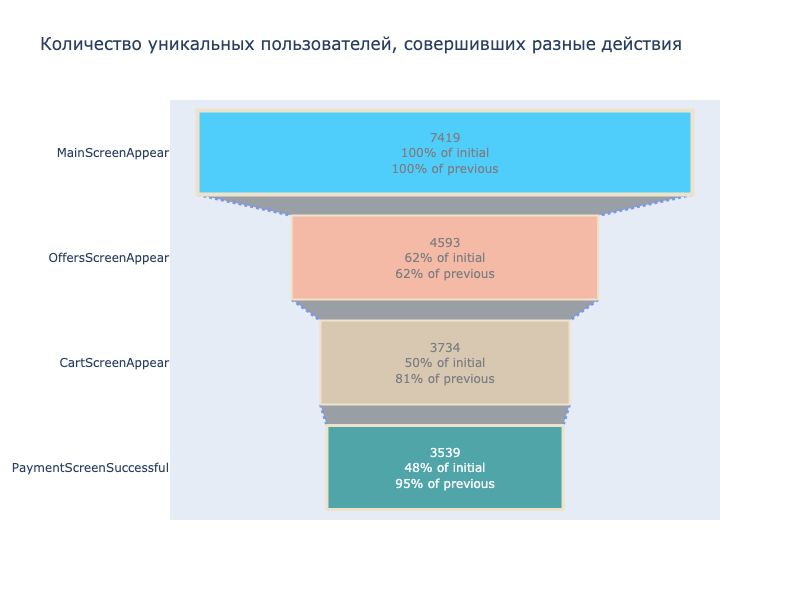

In [32]:
funnel = go.Figure(go.Funnel(
    y = n_users_by_event['event'],
    x = n_users_by_event['n_users'],
    textposition = "inside",
    textinfo = "value+percent initial+percent previous",
    opacity = 0.65,
    marker = {
        "color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"],
        "line": {
            "width": [4, 2, 2, 3, 1, 1],
            "color": ["wheat", "wheat", "wheat", "wheat", "wheat"]}},
    connector = {
        "line": {
            "color": "royalblue", "dash": "dot", "width": 3}})
    )

funnel.update_layout(title='Количество уникальных пользователей, совершивших разные действия')

funnel.show('png', width=800, height=600)

#### Где теряем больше всего пользователей

Из воронки видно, что наименьшая конверсия у главного экрана: с него на экран с товарами переходят 62% пользователей. То есть почти 40% просматривают только его и покидают приложение.

В асболютных значениях на главном экране мы потеряли 2826 пользователей. Это самый большой показатель как в абсолютном значении, так и относительно предыдущего экрана.

#### Доля пользователей, дошедших с первого экрана до покупки

От первого экрана приложения до оплаты дошли 3539 пользователей из 7419, или 48%.

Также отметим хорошую конверсию из корзины (предыдущий экран): 95% открывших ее совершили покупку.

[К содержанию](#Содержание)

## 5. Анализ результатов A/A/B-теста<a name="5.-Анализ-результатов-A/A/B-теста"></a>

Напомним, что мы тестировали новый шрифт в приложении. Для этого пользователей разбили на три группы:
- 246 и 247 группы контрольные для A/A-теста,
- 248 — тестовая с новым шрифтом.

Мы хотим проверить, влияет ли шрифт на то, как клиенты пользуются приложением. Будем сравнивать версии по использованию разных экранов. Если каким-нибудь экраном стала пользоватеться меньшая/большая доля клиентов в группе, значит, шрифт влияет на поведение пользователей.

### Размеры групп<a name="Размеры-групп"></a>

Посчитаем, сколько пользователей в каждой группе.

In [33]:
n_users_by_group = logs.groupby('group').agg({'user_id': 'nunique'})
n_users_by_group.columns = ['n_users']
n_users_by_group

,n_users
group,
246,2484
247,2513
248,2537


Размеры групп примерно равны: максимальная разница — 2% (между 246 и 248 группами). Нам подходит такая точность.

Запишем размеры групп в переменные.

In [34]:
def get_group_size(n_users_by_group, group_number):
    return n_users_by_group.loc[group_number, 'n_users']

In [35]:
size_246 = get_group_size(n_users_by_group, 246)
size_247 = get_group_size(n_users_by_group, 247)
size_248 = get_group_size(n_users_by_group, 248)

### Результаты A/A-теста<a name="Результаты-A/A-теста"></a>

Напишем функцию, которая будет собирать таблицу аналогичную `n_users_by_event`, но с данными для A/A- или A/B-теста.

In [36]:
def aggregate_group_data(logs, group, group_size):
    '''Функция для подсчета пользователей, совершивших каждое действие воронки'''
    n_users_by_event = (logs[(logs['event']!='Tutorial') & (logs['group']==group)]
                        .groupby('event')
                        .agg({'user_id': 'nunique'})
                        .reset_index())
    
    n_users_by_event.columns = ['event', 'n_users']
    n_users_by_event['percent_of_total'] = round(n_users_by_event['n_users'] / group_size * 100, 2)

    n_users_by_event = (n_users_by_event
                        .sort_values(by='n_users', ascending=False)
                        .reset_index(drop=True))
    return n_users_by_event

def aggregate_test_data(logs, groups):
    '''Функция для подсчета пользователей, совершивших каждое действие воронки в двух группах'''
    group_1, group_2 = groups
    
    n_users_by_group = logs.groupby('group').agg({'user_id': 'nunique'})
    n_users_by_group.columns = ['n_users']
    
    group_1_size = get_group_size(n_users_by_group, group_1)
    group_2_size = get_group_size(n_users_by_group, group_2)
    
    group_1_test_data = aggregate_group_data(logs, group_1, group_1_size)
    group_2_test_data = aggregate_group_data(logs, group_2, group_2_size)
    
    result = group_1_test_data.merge(group_2_test_data,
                                     on='event',
                                     suffixes=[f'_{group_1}', f'_{group_2}'])
    
    return result

Получим данные для A/A-теста.

In [37]:
aa_result = aggregate_test_data(logs, [246, 247])
aa_result

,event,n_users_246,percent_of_total_246,n_users_247,percent_of_total_247
0,MainScreenAppear,2450,98.63,2476,98.53
1,OffersScreenAppear,1542,62.08,1520,60.49
2,CartScreenAppear,1266,50.97,1238,49.26
3,PaymentScreenSuccessful,1200,48.31,1158,46.08


Для наглядности построим воронку.

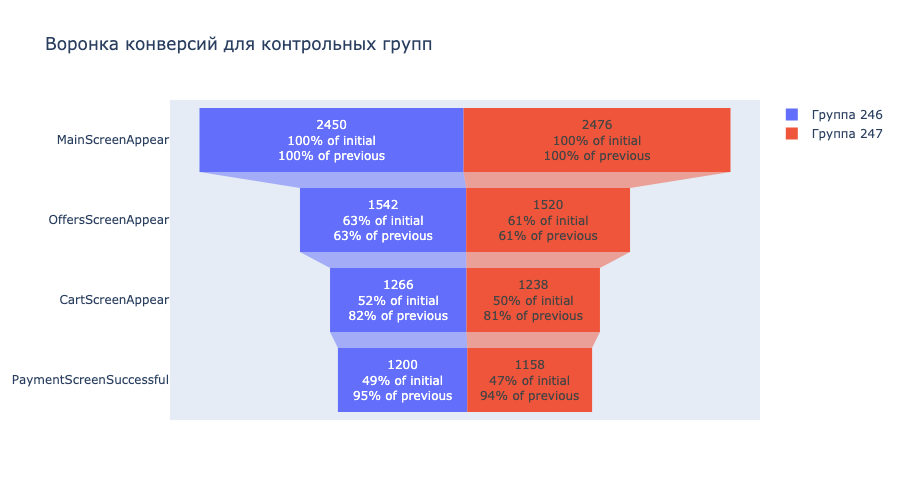

In [38]:
funnel_aa = go.Figure()

funnel_aa.add_trace(go.Funnel(
    name = 'Группа 246',
    y = aa_result['event'],
    x = aa_result['n_users_246'],
    textinfo = 'value+percent initial+percent previous'))

funnel_aa.add_trace(go.Funnel(
    name = 'Группа 247',
    y = aa_result['event'],
    x = aa_result['n_users_247'],
    textinfo = 'value+percent initial+percent previous'))

funnel_aa.update_layout(
    title='Воронка конверсий для контрольных групп'
)

funnel_aa.show('png', width=900, height=500)

Воронка выглядит симметрично, однако небольшие (максимум 2%) отклонения в конверсиях есть. Проверим их статзначиость.

In [39]:
def ztests_for_experiment(test_result, groups_sizes, alpha=0.05):
    for screen_number in range(len(test_result)):
        event = aa_result.loc[screen_number, :][0]
        gr_1_users = aa_result.loc[screen_number, :][1]
        gr_2_users = aa_result.loc[screen_number, :][3]
        
        offset = ' ' * 2
        h0 = f'{offset}H0: доля пользователей, открывших экран {event}, в обеих группах \033[1mравна \033[0m'
        h1 = f'{offset}H1: доля пользователей, открывших экран {event}, \033[1mразличается \033[0m'
        
        print('\033[1m'+f'Экран {event}, z-тест для двух долей '+'\033[0m')
        print(h0)
        print(h1)
        
        zstat, p_value = proportions_ztest([gr_1_users, gr_2_users], groups_sizes)
        
        print(f'{offset}Уровень значимости: {alpha}')
        print(f'{offset}p-значение в тесте: {round(p_value, 4)}')
        
        if p_value < alpha:
            print(f'{offset}\033[1mОтклоняем нулевую гипотезу.\033[0m Доли в группах различаются статзначимо')
        else:
            print(f'{offset}\033[1mНе получилось отклонить нулевую гипотезу\033[0m. Различия в долях по группам не статзначимы')
        print()        

Будем считать, что поведение пользователей в группах различается, если хотя бы один из экранов открыла меньшая доля пользоваталей. Возьмем уровень статзначимости `alpha = 0.05`.

На двух выборках мы будем проводить 4 сравнения. В таком случае, если для каждого сравнения мы возьмем уровень значимости `alpha`, то вероятность случайно отклонить нулевую гипотезу в одном из тестов возрастет до `1 - (1-alpha)^4 ≈ 0.19`. А мы хотим `0.05`.

Чтобы это исправить, сделаем поправку на множественную проверку гипотез. Воспользуемся формулой Бонферрони: разделим `alpha` на количество сравнений.

In [40]:
alpha = 0.05
n_tests = len(aa_result)
alpha_adj = alpha / n_tests

ztests_for_experiment(aa_result, [size_246, size_247], alpha_adj)            

Экран MainScreenAppear, z-тест для двух долей 
  H0: доля пользователей, открывших экран MainScreenAppear, в обеих группах равна 
  H1: доля пользователей, открывших экран MainScreenAppear, различается 
  Уровень значимости: 0.0125
  p-значение в тесте: 0.7571
  Не получилось отклонить нулевую гипотезу. Различия в долях по группам не статзначимы

Экран OffersScreenAppear, z-тест для двух долей 
  H0: доля пользователей, открывших экран OffersScreenAppear, в обеих группах равна 
  H1: доля пользователей, открывших экран OffersScreenAppear, различается 
  Уровень значимости: 0.0125
  p-значение в тесте: 0.2481
  Не получилось отклонить нулевую гипотезу. Различия в долях по группам не статзначимы

Экран CartScreenAppear, z-тест для двух долей 
  H0: доля пользователей, открывших экран CartScreenAppear, в обеих группах равна 
  H1: доля пользователей, открывших экран CartScreenAppear, различается 
  Уровень значимости: 0.0125
  p-значение в тесте: 0.2288
  Не получилось отклонить нулевую г

Ни для одного из экранов доля открывших его пользователей в разных группах не различается статзначимо.

**Вывод:** A/A-тест проведен корректно, группы в нем не различаются.

### Результаты A/B-теста<a name="Результаты-A/B-теста"></a>

Получим данные по A/B-тесту и построим для него воронку событий. Из контрольных групп возьмем 247, потому что ее размер ближе к тестовой.

In [41]:
ab_result = aggregate_test_data(logs, [247, 248])
ab_result

,event,n_users_247,percent_of_total_247,n_users_248,percent_of_total_248
0,MainScreenAppear,2476,98.53,2493,98.27
1,OffersScreenAppear,1520,60.49,1531,60.35
2,CartScreenAppear,1238,49.26,1230,48.48
3,PaymentScreenSuccessful,1158,46.08,1181,46.55


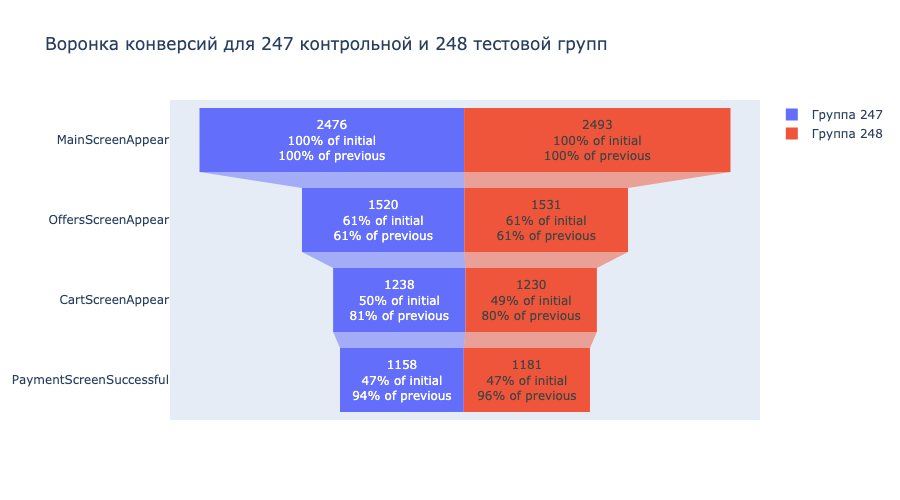

In [42]:
funnel_ab = go.Figure()

funnel_ab.add_trace(go.Funnel(
    name = 'Группа 247',
    y = ab_result['event'],
    x = ab_result['n_users_247'],
    textinfo = 'value+percent initial+percent previous'))

funnel_ab.add_trace(go.Funnel(
    name = 'Группа 248',
    y = ab_result['event'],
    x = ab_result['n_users_248'],
    textinfo = 'value+percent initial+percent previous'))

funnel_ab.update_layout(
    title='Воронка конверсий для 247 контрольной и 248 тестовой групп'
)

funnel_ab.show('png', width=900, height=500)

Здесь на первый взгляд различия еще меньше, чем между контрольными группами. Видимо, шрифт не влияет на пользование приложением. Проверим это с помощью статтеста.

Будем считать, что поведение пользователей в группах различается, если хотя бы один из экранов открыла меньшая доля пользоваталей. Возьмем уровень статзначимости alpha = 0.05.

На двух выборках мы будем проводить 4 сравнения. В таком случае, если для каждого сравнения мы возьмем уровень значимости alpha, то вероятность случайно отклонить нулевую гипотезу в одном из тестов возрастет до 1 - (1-alpha)^4 ≈ 0.19. А мы хотим 0.05.

Чтобы это исправить, сделаем поправку на множественную проверку гипотез. Воспользуемся формулой Бонферрони: разделим alpha на количество сравнений.

In [43]:
alpha = 0.05
n_tests = len(aa_result)
alpha_adj = alpha / n_tests

ztests_for_experiment(aa_result, [size_247, size_248], alpha_adj)

Экран MainScreenAppear, z-тест для двух долей 
  H0: доля пользователей, открывших экран MainScreenAppear, в обеих группах равна 
  H1: доля пользователей, открывших экран MainScreenAppear, различается 
  Уровень значимости: 0.0125
  p-значение в тесте: 0.8139
  Не получилось отклонить нулевую гипотезу. Различия в долях по группам не статзначимы

Экран OffersScreenAppear, z-тест для двух долей 
  H0: доля пользователей, открывших экран OffersScreenAppear, в обеих группах равна 
  H1: доля пользователей, открывших экран OffersScreenAppear, различается 
  Уровень значимости: 0.0125
  p-значение в тесте: 0.2924
  Не получилось отклонить нулевую гипотезу. Различия в долях по группам не статзначимы

Экран CartScreenAppear, z-тест для двух долей 
  H0: доля пользователей, открывших экран CartScreenAppear, в обеих группах равна 
  H1: доля пользователей, открывших экран CartScreenAppear, различается 
  Уровень значимости: 0.0125
  p-значение в тесте: 0.2614
  Не получилось отклонить нулевую г

Ни у одного из экранов доля воспользовавшихся им клиентов в контрольной и тестовой выборках не различается статзначимо.

Отметим, что во всех тестах мы получили большие p-значения: меньшая из них — 13%. То есть даже без поправки Бонферрони при уровне статзначиости в 5% ни один тест не показал бы значимых различий.

**Вывод:** по результатам A/B-теста можно сказать, что изменине шрифта в приложении не повлияло на поведение пользователей в нем.

[К содержанию](#Содержание)

## Общий вывод<a name="Общий-вывод"></a>

У нашего исследования две задачи: изучить воронку продаж и результаты A/A/B-теста нового шрифта. Обе мы решили! Вспомним решение и посмотрим на выводы.

В начале мы познакомились с данными и нашли в них несколько проблем:

1. Поменяли названия столбцов на удобные и говорящие.
2. Поменяли тип данных `timestamp` с неправильного `int` на подходящий `datetime`.
3. Нашли в данных дубликаты и удалили их.

Можно рассказать об этих моментах команде разработки, чтобы в следующий раз данные пришли правильными.

Также мы удостоверились, что пользователи не меняли свои группы во время теста.

После исправления ошибок мы продолжили изучение логов. Оказалось, что мы получили «грязные» данные за неделю. «Грязные» потому, что в них содержались сведения о предыдущей неделе. Мы избавились от них и из-за этого потеряли 2826 логов. Но они составляли всего 1,16% изначального датафрейма. Вместе с этими логами мы лишились сведений о 17, но их доля от общего числа была еще меньше — 0,23%.

### Воронка событий<a name="Воронка-событий"></a>

По подготовленным данным мы построили воронку с числом пользователей, добравшихся до каждого экрана:

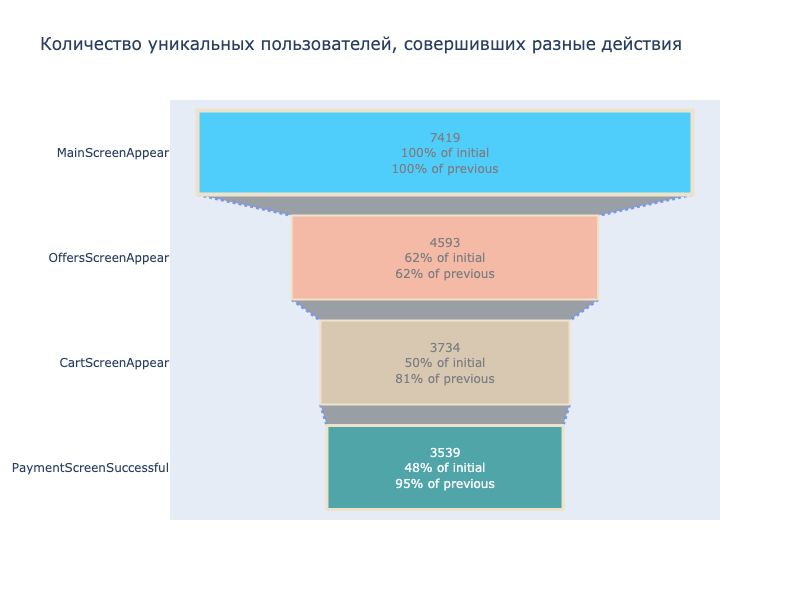

In [44]:
funnel.show('png', width=800, height=600)

**Где теряем больше всего пользователей**

Из воронки видно, что наименьшая конверсия у главного экрана: с него на экран с товарами переходят 62% пользователей. То есть почти 40% просматривают только его и покидают приложение.

В асболютных значениях на главном экране мы потеряли 2826 пользователей. Это самый большой показатель как в абсолютном значении, так и относительно предыдущего экрана.

**Доля пользователей, дошедших с первого экрана до покупки**

От первого экрана приложения до оплаты дошли 3539 пользователей из 7419, или 48%.

Также отметим хорошую конверсию из корзины (предыдущий экран): 95% открывших ее совершили покупку.

### A/A-тест<a name="A/A-тест"></a>

После анализа воронки мы перешли ко второй задаче проекта — анализу A/A/B-теста.

Сначала мы проанализировали A/A-тест. Пришли к выводу, что разбиение на группы работает корректно, так как статистически значимых различий в конверсиях контрольных групп не обнаружилось.

In [45]:
ztests_for_experiment(aa_result, [size_246, size_247], alpha_adj)

Экран MainScreenAppear, z-тест для двух долей 
  H0: доля пользователей, открывших экран MainScreenAppear, в обеих группах равна 
  H1: доля пользователей, открывших экран MainScreenAppear, различается 
  Уровень значимости: 0.0125
  p-значение в тесте: 0.7571
  Не получилось отклонить нулевую гипотезу. Различия в долях по группам не статзначимы

Экран OffersScreenAppear, z-тест для двух долей 
  H0: доля пользователей, открывших экран OffersScreenAppear, в обеих группах равна 
  H1: доля пользователей, открывших экран OffersScreenAppear, различается 
  Уровень значимости: 0.0125
  p-значение в тесте: 0.2481
  Не получилось отклонить нулевую гипотезу. Различия в долях по группам не статзначимы

Экран CartScreenAppear, z-тест для двух долей 
  H0: доля пользователей, открывших экран CartScreenAppear, в обеих группах равна 
  H1: доля пользователей, открывших экран CartScreenAppear, различается 
  Уровень значимости: 0.0125
  p-значение в тесте: 0.2288
  Не получилось отклонить нулевую г

### A/B-тест<a name="A/B-тест"></a>

Затем мы сравнили контрольную и тестовые группы.

In [46]:
ztests_for_experiment(aa_result, [size_247, size_248], alpha_adj)

Экран MainScreenAppear, z-тест для двух долей 
  H0: доля пользователей, открывших экран MainScreenAppear, в обеих группах равна 
  H1: доля пользователей, открывших экран MainScreenAppear, различается 
  Уровень значимости: 0.0125
  p-значение в тесте: 0.8139
  Не получилось отклонить нулевую гипотезу. Различия в долях по группам не статзначимы

Экран OffersScreenAppear, z-тест для двух долей 
  H0: доля пользователей, открывших экран OffersScreenAppear, в обеих группах равна 
  H1: доля пользователей, открывших экран OffersScreenAppear, различается 
  Уровень значимости: 0.0125
  p-значение в тесте: 0.2924
  Не получилось отклонить нулевую гипотезу. Различия в долях по группам не статзначимы

Экран CartScreenAppear, z-тест для двух долей 
  H0: доля пользователей, открывших экран CartScreenAppear, в обеих группах равна 
  H1: доля пользователей, открывших экран CartScreenAppear, различается 
  Уровень значимости: 0.0125
  p-значение в тесте: 0.2614
  Не получилось отклонить нулевую г

Ни у одного из экранов доля воспользовавшихся им клиентов в контрольной и тестовой выборках не различается статзначимо.

**Вывод:** по результатам A/B-теста можно сказать, что изменине шрифта в приложении не повлияло на поведение пользователей в нем.

[К содержанию](#Содержание)